# Simple PINN for an elastic plate with a hole 

In [14]:
import pandas as pd
import torch 
inpvalues03 = pd.read_csv('data\inputs_Rx=0.3.csv')
inpvalues035 = pd.read_csv('data\inputs_Rx=0.35.csv')
inpvalues04 = pd.read_csv('data\inputs_Rx=0.4.csv')
inpvalues045 = pd.read_csv('data\inputs_Rx=0.45.csv')
inpvalues05 = pd.read_csv('data\inputs_Rx=0.5.csv')
inpvalues055 = pd.read_csv('data\inputs_Rx=0.55.csv')
inpvalues06 = pd.read_csv('data\inputs_Rx=0.6.csv')
inpvalues065 = pd.read_csv('data\inputs_Rx=0.65.csv')
inpvalues07 = pd.read_csv('data\inputs_Rx=0.7.csv')
inpvalues075 = pd.read_csv('data\inputs_Rx=0.75.csv')
inpvalues08 = pd.read_csv('data\inputs_Rx=0.8.csv')

outvalues03 = pd.read_csv('data\outputs_Rx=0.3.csv')
outvalues035 = pd.read_csv('data\outputs_Rx=0.35.csv')
outvalues04 = pd.read_csv('data\outputs_Rx=0.4.csv')
outvalues045 = pd.read_csv('data\outputs_Rx=0.45.csv')
outvalues05 = pd.read_csv('data\outputs_Rx=0.5.csv')
outvalues055 = pd.read_csv('data\outputs_Rx=0.55.csv')
outvalues06 = pd.read_csv('data\outputs_Rx=0.6.csv')
outvalues065 = pd.read_csv('data\outputs_Rx=0.65.csv')
outvalues07 = pd.read_csv('data\outputs_Rx=0.7.csv')
outvalues075 = pd.read_csv('data\outputs_Rx=0.75.csv')
outvalues08 = pd.read_csv('data\outputs_Rx=0.8.csv')

inputs_Rx_03 = torch.tensor(inpvalues03.to_numpy(),dtype = torch.float32,  requires_grad=True)
inputs_Rx_035 = torch.tensor(inpvalues035.to_numpy(),dtype = torch.float32,  requires_grad=True)
inputs_Rx_04 = torch.tensor(inpvalues04.to_numpy(),dtype = torch.float32,  requires_grad=True)
inputs_Rx_045 = torch.tensor(inpvalues045.to_numpy(),dtype = torch.float32,  requires_grad=True)
inputs_Rx_05 = torch.tensor(inpvalues05.to_numpy(),dtype = torch.float32,  requires_grad=True)
inputs_Rx_055 = torch.tensor(inpvalues055.to_numpy(),dtype = torch.float32,  requires_grad=True)
inputs_Rx_06 = torch.tensor(inpvalues06.to_numpy(),dtype = torch.float32,  requires_grad=True)
inputs_Rx_065 = torch.tensor(inpvalues065.to_numpy(),dtype = torch.float32,  requires_grad=True)
inputs_Rx_07 = torch.tensor(inpvalues07.to_numpy(),dtype = torch.float32,  requires_grad=True)
inputs_Rx_075 = torch.tensor(inpvalues075.to_numpy(),dtype = torch.float32,  requires_grad=True)
inputs_Rx_08 = torch.tensor(inpvalues08.to_numpy(),dtype = torch.float32,  requires_grad=True)

outputs_Rx_03 = torch.tensor(outvalues03.to_numpy(),dtype = torch.float32,  requires_grad=True)
outputs_Rx_035 = torch.tensor(outvalues035.to_numpy(),dtype = torch.float32,  requires_grad=True)
outputs_Rx_04 = torch.tensor(outvalues04.to_numpy(),dtype = torch.float32,  requires_grad=True)
outputs_Rx_045 = torch.tensor(outvalues045.to_numpy(),dtype = torch.float32,  requires_grad=True)
outputs_Rx_05 = torch.tensor(outvalues05.to_numpy(),dtype = torch.float32,  requires_grad=True)
outputs_Rx_055 = torch.tensor(outvalues055.to_numpy(),dtype = torch.float32,  requires_grad=True)
outputs_Rx_06 = torch.tensor(outvalues06.to_numpy(),dtype = torch.float32,  requires_grad=True)
outputs_Rx_065 = torch.tensor(outvalues065.to_numpy(),dtype = torch.float32,  requires_grad=True)
outputs_Rx_07 = torch.tensor(outvalues07.to_numpy(),dtype = torch.float32,  requires_grad=True)
outputs_Rx_075 = torch.tensor(outvalues075.to_numpy(),dtype = torch.float32,  requires_grad=True)
outputs_Rx_08 = torch.tensor(outvalues08.to_numpy(),dtype = torch.float32,  requires_grad=True)

## Generating the data and build the neural network



In [15]:
import torch
import functorch
import numpy as np
from scipy.stats import qmc
import matplotlib.pyplot as plt
import random
from math import pi, ceil
from plate_elliptic_hole import Plate 

from global_constants import L, R, B0, EPS0, MU, LBD, RATIO

# Applied strain at right boundary
EPS0 = 0.1
# Applied body force field
B0 = 0.0
# Lame constants
MU = 1
LBD = 2

Ra_x = 0.7 #radius on the x-axis of the ellipse 
SuAr= 0.25*pi   #surface area of the eclipse (= equal to SuAr of a circle with R=0.5)
Min_Ra_x = 0.3
Max_Ra_x = 0.8
# Min_Ra_x_train = 0.5 #minimal radius on the x-axis of the ellipse
# Max_Ra_x_train = 0.8 #maximum radius on the x-axis of the ellipse
# Min_Ra_x_test = 0.25 #minimal radius on the x-axis of the ellipse
# Max_Ra_x_test = 0.5 #maximum radius on the x-axis of the ellipse

L = 1 #length of plate #info: muss noch gefixt werden -> momentan bei 1 lassen
N = 20 #number of collocation Point in x-axis direction
P = 22 #number of plates in dataset #11 plates
NN = ceil(N * (L-Ra_x)/L) #number of collocation Point in both direction

def generate_radii_list(iteration, min_Ra_x, max_Ra_x):
    rad_x_list = np.linspace(min_Ra_x, max_Ra_x, iteration)
    rad_y_list = []
    for rad_x in rad_x_list:
        rad_y_list.append(SuAr/(pi*rad_x))
    return rad_x_list, rad_y_list

def generate_multiple_plates_dict(iteration, min_Ra_x, max_Ra_x):
    dict_plate_points = dict()
    tuples = [
            ("x_collo", 0, 0),
            ("y_collo", 0, 1),
            ("r_collo", 0, 2),
            ("x_top", 1, 0),
            ("y_top", 1, 1),
            ("r_top", 1, 2),
            ("x_right", 2, 0),
            ("y_right", 2, 1),
            ("r_right", 2, 2),
            ("x_left", 3, 0),
            ("y_left", 3, 1),
            ("r_left", 3, 2),
            ("x_bottom", 4, 0),
            ("y_bottom", 4, 1),
            ("r_bottom", 4, 2),
            ("x_hole", 5, 0),
            ("y_hole", 5, 1),
            ("r_hole", 5, 2),
            
        ] 
    
    ra_x_list, ra_y_list = generate_radii_list(iteration, min_Ra_x, max_Ra_x)
    for i in range(iteration):
        p1 = Plate(Ra_x, SuAr, L, N)
        data_one_plate = p1.generate_dataset_new(ra_x_list[i], ra_y_list[i], L, N)
        for tuple in tuples:
            key = tuple[0]
            dict_plate_points.setdefault(key, []).append(data_one_plate[tuple[1]][tuple[2]])
        #p1.plot_plate_with_hole_new(*data_one_plate)
    for key in dict_plate_points: 
        #print(key, "  ",dict_plate_points[key])
        #appending list of tensors to one tensor
        dict_plate_points[key] = torch.cat(dict_plate_points[key])
        #print(key, "  ",dict_plate_points[key])
        #print(key, "shape is", dict_plate_points[key].size())
    #print(dict_plate_points)
    #print("Der Datensatz besteht aus",dict_plate_points["x_collo"].size(), "Datenpunkten" )
    #print("Der Datensatz besteht aus",dict_plate_points["y_collo"].size(), "Datenpunkten" )
    #print("Der Datensatz besteht aus",dict_plate_points["r_collo"].size(), "Datenpunkten" )
    collo_points = torch.column_stack([dict_plate_points["x_collo"], dict_plate_points["y_collo"], dict_plate_points["r_collo"]])
    top_points = torch.column_stack([dict_plate_points["x_top"], dict_plate_points["y_top"], dict_plate_points["r_top"]])
    right_points = torch.column_stack([dict_plate_points["x_right"], dict_plate_points["y_right"], dict_plate_points["r_right"]])
    left_points = torch.column_stack([dict_plate_points["x_left"], dict_plate_points["y_left"], dict_plate_points["r_left"]])
    bottom_points = torch.column_stack([dict_plate_points["x_bottom"], dict_plate_points["y_bottom"], dict_plate_points["r_bottom"]])
    hole_points = torch.column_stack([dict_plate_points["x_hole"], dict_plate_points["y_hole"], dict_plate_points["r_hole"]])

    return collo_points, top_points, right_points, left_points, bottom_points, hole_points


p2 = Plate(Ra_x, SuAr, L, N)
Re_xnew, Re_ynew = p2.create_ellipse(Ra_x,SuAr, L)
#p2.plot_quarter_elli(Re_xnew, Re_ynew)
train_plates_data = generate_multiple_plates_dict(P, Min_Ra_x, Max_Ra_x)
test_plates_data = generate_multiple_plates_dict(P,Min_Ra_x, Max_Ra_x)
n_hole_points = train_plates_data[5]
#print("Der Datensatz besteht aus", train_plates_data[1].shape, "Datenpunkten" )

#data_train_points = p2.generate_dataset_test(Re_xnew, Re_ynew, L, N)
#data_test_points = p2.generate_dataset_test(Re_xnew, Re_ynew, L, N)
#p2.plot_plate_with_hole_old(*data_train_points)
#p2.plot_plate_with_hole(*data_test_points)



n_hole =  tensor([[-8.3333e-01, -0.0000e+00],
        [-8.1732e-01, -5.8527e-02],
        [-7.6990e-01, -1.1481e-01],
        [-6.9289e-01, -1.6667e-01],
        [-5.8926e-01, -2.1213e-01],
        [-4.6298e-01, -2.4944e-01],
        [-3.1890e-01, -2.7716e-01],
        [-1.6258e-01, -2.9424e-01],
        [-5.1027e-17, -3.0000e-01]])
new_n_hole =  tensor([[-8.3333e-01, -0.0000e+00],
        [-8.1732e-01, -5.8527e-02],
        [-7.6990e-01, -1.1481e-01],
        [-6.9289e-01, -1.6667e-01],
        [-5.8926e-01, -2.1213e-01],
        [-4.6298e-01, -2.4944e-01],
        [-3.1890e-01, -2.7716e-01],
        [-1.6258e-01, -2.9424e-01],
        [-5.1027e-17, -3.0000e-01]], grad_fn=<TBackward0>)
n_hole =  tensor([[-8.3333e-01, -0.0000e+00],
        [-8.1732e-01, -5.8527e-02],
        [-7.6990e-01, -1.1481e-01],
        [-6.9289e-01, -1.6667e-01],
        [-5.8926e-01, -2.1213e-01],
        [-4.6298e-01, -2.4944e-01],
        [-3.1890e-01, -2.7716e-01],
        [-1.6258e-01, -2.9424e-01],
      

In [16]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        hn = 20
        self.hidden_layer1 = torch.nn.Linear(3,hn)
        self.hidden_layer2 = torch.nn.Linear(hn,hn)
        self.hidden_layer3 = torch.nn.Linear(hn,hn)
        self.hidden_layer4 = torch.nn.Linear(hn,hn)
        self.hidden_layer5 = torch.nn.Linear(hn,hn)
        self.output_layer = torch.nn.Linear(hn,2)

    def forward(self, inputs):
        layer1_out = torch.tanh(self.hidden_layer1(inputs))
        layer2_out = torch.tanh(self.hidden_layer2(layer1_out))
        layer3_out = torch.tanh(self.hidden_layer3(layer2_out))
        layer4_out = torch.tanh(self.hidden_layer4(layer3_out))
        layer5_out = torch.tanh(self.hidden_layer5(layer4_out))
        output = self.output_layer(layer5_out)
        return output

## The physics

We want to solve linear elasticity on the domain, which means ultimately that we want to minimize the residual of the PDE 
$$
    \nabla \cdot \sigma - \mathbf{b} = \mathbf{0}. 
$$

In [17]:
def sigma(eps):
    I = torch.eye(2)
    return 2.0 * MU * eps + LBD * torch.einsum("...ii,...jk->...jk", eps, I)

def epsilon(x, y, r, net):
    inputs = torch.column_stack([x,y,r])
    disp = net(inputs)
    u = disp[:,0]
    v = disp[:,1]
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    v_x = torch.autograd.grad(v.sum(), x, create_graph=True)[0]
    u_y = torch.autograd.grad(u.sum(), y, create_graph=True)[0]
    v_y = torch.autograd.grad(v.sum(), y, create_graph=True)[0]

    gradx = torch.column_stack([u_x, v_x])
    grady = torch.column_stack([u_y, v_y])
    gradient = torch.stack([gradx, grady], dim=2)

    return 0.5 * (gradient + torch.transpose(gradient, 1, 2))

def pde_residual(x, y, r, net):
    stress = sigma(epsilon(x,y,r, net))
    sxx = stress[:,0,0]
    sxy = stress[:,0,1]
    syx = stress[:,1,0]
    syy = stress[:,1,1]
    

    sxx_x = torch.autograd.grad(sxx.sum(), x, create_graph=True)[0]
    sxy_y = torch.autograd.grad(sxy.sum(), y, create_graph=True)[0]
    syx_x = torch.autograd.grad(syx.sum(), x, create_graph=True)[0]
    syy_y = torch.autograd.grad(syy.sum(), y, create_graph=True)[0]

    residual_x = sxx_x + sxy_y - B0
    residual_y = syx_x + syy_y
    return residual_x, residual_y


## The loss function

In [18]:
W_PDE = 0.01
W_NEUMANN = 0.01
W_DATA = 0

mse = torch.nn.MSELoss()


def compute_loss(net, collo_points, top_points, right_points, left_points, bottom_points, hole_points):

    # pde
    res_x, res_y = pde_residual(collo_points[:,0],collo_points[:,1],collo_points[:,2], net)
    zeros = torch.zeros_like(res_x)
    pde_error = mse(res_x, zeros) + mse(res_y, zeros)

    # left boundary
    pred_left = net(left_points)
    bc_left = torch.zeros_like(pred_left[:,0])
    left_error = mse(pred_left[:,0], bc_left) 

    # right boundary
    pred_right = net(right_points)
    bc_right = EPS0 * L * torch.ones_like(pred_right[:,0])
    right_error = mse(pred_right[:,0], bc_right) 

    # bottom boundary
    pred_bottom = net(bottom_points)
    bc_bottom = torch.zeros_like(pred_bottom[:,1])
    bottom_error = mse(pred_bottom[:,1], bc_bottom) 

    # top boundary
    stress_top = sigma(epsilon(top_points[:,0],top_points[:,1],top_points[:,2], net))
    #old top error
    #zeros = torch.zeros_like(stress_top[:,1,1])
    #top_error = mse(stress_top[:,1,1], zeros) + mse(stress_top[:,0,1], zeros)
    #new top error
    pred_top = net(top_points)
    bc_top = RATIO * EPS0 * L * torch.ones_like(pred_top[:,1])
    top_error = mse(pred_top[:,1], bc_top)

    # hole boundary
    stress_hole = sigma(epsilon(hole_points[:,0], hole_points[:,1], hole_points[:,2], net))
    x = ((hole_points[:,0]/hole_points[:,2] * -(SuAr/(pi*hole_points[:,2]))))
    y = ((hole_points[:,1]/(SuAr/(pi*hole_points[:,2]))) * -hole_points[:,2])
    n_hole = torch.t(torch.vstack([x,y]))
    traction = torch.einsum("...ij,...j->...i", stress_hole, n_hole)
    zeros = torch.zeros_like(traction[:,0])
    hole_error = mse(traction[:,0], zeros) + mse(traction[:,1], zeros)


    # data error
    strain_03 = epsilon(inputs_Rx_03[:,0], inputs_Rx_03[:,1], inputs_Rx_03[:,2], net).detach()
    pred_stress_03 = sigma(strain_03).detach()
    DATA_error_03 = mse(pred_stress_03[:, 0, 0], outputs_Rx_03[:,0])
    strain_035 = epsilon(inputs_Rx_035[:,0], inputs_Rx_035[:,1], inputs_Rx_035[:,2], net).detach()
    pred_stress_035 = sigma(strain_035).detach()
    DATA_error_035 = mse(pred_stress_035[:, 0, 0], outputs_Rx_035[:,0])
    strain_04 = epsilon(inputs_Rx_04[:,0], inputs_Rx_04[:,1], inputs_Rx_04[:,2], net).detach()
    pred_stress_04 = sigma(strain_04).detach()
    DATA_error_04 = mse(pred_stress_04[:, 0, 0], outputs_Rx_04[:,0])
    strain_045 = epsilon(inputs_Rx_045[:,0], inputs_Rx_045[:,1], inputs_Rx_045[:,2], net).detach()
    pred_stress_045 = sigma(strain_045).detach()
    DATA_error_045 = mse(pred_stress_045[:, 0, 0], outputs_Rx_045[:,0])
    strain_05 = epsilon(inputs_Rx_05[:,0], inputs_Rx_05[:,1], inputs_Rx_05[:,2], net).detach()
    pred_stress_05 = sigma(strain_05).detach()
    DATA_error_05 = mse(pred_stress_05[:, 0, 0], outputs_Rx_05[:,0])
    strain_055 = epsilon(inputs_Rx_055[:,0], inputs_Rx_055[:,1], inputs_Rx_055[:,2], net).detach()
    pred_stress_055 = sigma(strain_055).detach()
    DATA_error_055 = mse(pred_stress_055[:, 0, 0], outputs_Rx_055[:,0])
    strain_06 = epsilon(inputs_Rx_06[:,0], inputs_Rx_06[:,1], inputs_Rx_06[:,2], net).detach()
    pred_stress_06 = sigma(strain_06).detach()
    DATA_error_06 = mse(pred_stress_06[:, 0, 0], outputs_Rx_06[:,0])
    strain_065 = epsilon(inputs_Rx_065[:,0], inputs_Rx_065[:,1], inputs_Rx_065[:,2], net).detach()
    pred_stress_065 = sigma(strain_065).detach()
    DATA_error_065 = mse(pred_stress_065[:, 0, 0], outputs_Rx_065[:,0])
    strain_07 = epsilon(inputs_Rx_07[:,0], inputs_Rx_07[:,1], inputs_Rx_07[:,2], net).detach()
    pred_stress_07 = sigma(strain_07).detach()
    DATA_error_07 = mse(pred_stress_07[:, 0, 0], outputs_Rx_07[:,0])
    strain_075 = epsilon(inputs_Rx_075[:,0], inputs_Rx_075[:,1], inputs_Rx_075[:,2], net).detach()
    pred_stress_075 = sigma(strain_075).detach()
    DATA_error_075 = mse(pred_stress_075[:, 0, 0], outputs_Rx_075[:,0])
    strain_08 = epsilon(inputs_Rx_08[:,0], inputs_Rx_08[:,1], inputs_Rx_08[:,2], net).detach()
    pred_stress_08 = sigma(strain_08).detach()
    DATA_error_08 = mse(pred_stress_08[:, 0, 0], outputs_Rx_08[:,0])

    total_DATA_error = DATA_error_03 + DATA_error_035 + DATA_error_04 + DATA_error_045 + DATA_error_05 + DATA_error_055 + DATA_error_06 + DATA_error_065 + DATA_error_07 + DATA_error_075 + DATA_error_08

    return (
        left_error
        + right_error
        + bottom_error
        + top_error
        + W_NEUMANN * hole_error
        + W_PDE * pde_error
        + W_DATA * total_DATA_error
    )




## Training 

dataset: N: 20 plates: 22
starting learning rate: 0.01 and gamma: 0.4 , epochs: 1000 iterations: 4
Epoch: 0
Learing rate: [0.01]
Epoch: 250
Learing rate: [0.004]
Epoch: 500
Learing rate: [0.0016]
Epoch: 750
Learing rate: [0.00064]


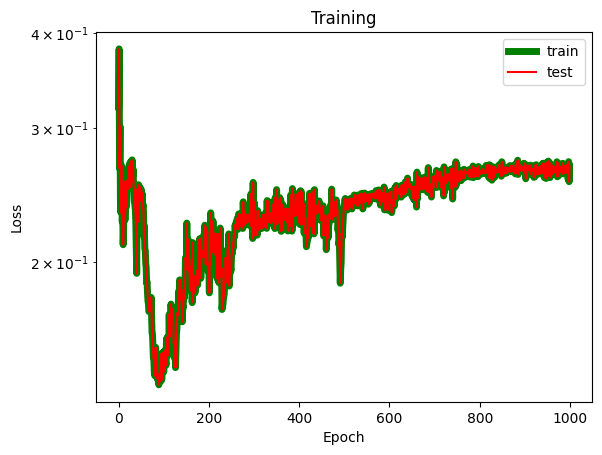

In [19]:
from torch.optim.lr_scheduler import LambdaLR, ExponentialLR, StepLR, ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader

net = Net()
train_data = []
test_data = []
epochs = 1000
iterations = 4
epochs_per_iter = int(epochs/iterations)
LeRa = 0.01
gamma = 0.4
batches = 4



#""""
optimizer = torch.optim.Adam(net.parameters(), LeRa)
scheduler = StepLR(optimizer, step_size=epochs_per_iter, gamma= gamma)
#train_data_loader = DataLoader(train_plates_data, batch_size = 7)
#print(train_data_loader.dataset[6])
#scheduler = ExponentialLR(optimizer, gamma=0.9)


print("dataset: N:", N, "plates:", P)
print("starting learning rate:", LeRa, "and gamma:", gamma, ", epochs:", epochs, "iterations:", iterations)
for epoch in range(epochs):
    if epoch % epochs_per_iter == 0:
        print(f"Epoch: {epoch}")
        print(f"Learing rate: {scheduler.get_last_lr()}")
    #rearrange points random
    shuffled_train_plates_data = []
    shuffled_test_plates_data = []
    for data in train_plates_data:
        permutation = data[torch.randperm(data.size()[0])]
        shuffled_train_plates_data.append(permutation)
    for data in test_plates_data:
        permutation = data[torch.randperm(data.size()[0])]
        shuffled_test_plates_data.append(permutation)
    #split up data in batches
    for i in range(batches):
        #print("batch nr", i+1)
        train_plates_data_batch = []
        test_plates_data_batch = []
        for data in shuffled_train_plates_data:
            train_plates_data_batch.append(data[i+1::batches])
        for data in shuffled_test_plates_data:
            test_plates_data_batch.append(data[i+1::batches])
            #print(len(data))
            #print(len(data[i+1::batch_size]))
            #print(len(train_plates_data_batch))
        optimizer.zero_grad()
        #old code
        #loss_train = compute_loss(net, *train_plates_data.values(), rad_x)
        #loss_test = compute_loss(net, *test_plates_data.values(), rad_x)
        #new code
        loss_train = compute_loss(net, *train_plates_data_batch)
        loss_test = compute_loss(net, *test_plates_data_batch)
        loss_train.backward(retain_graph=True)
        optimizer.step()
    scheduler.step()
        #print(scheduler.get_lr())
    with torch.autograd.no_grad():
        train_data.append(float(loss_train.data))
        test_data.append(float(loss_test.data)) 


# print("dataset: N:", N, "plates:", P)
# print("starting learning rate:", LeRa, "and gamma:", gamma, ", epochs:", epochs, "iterations:", iterations)
# for epoch in range(epochs):
#     if epoch % 500 == 0:
#         print(f"Epoch: {epoch}")
#     optimizer.zero_grad()
#     #old code
#     #loss_train = compute_loss(net, *train_plates_data.values(), rad_x)
#     #loss_test = compute_loss(net, *test_plates_data.values(), rad_x)
#     #new code
#     loss_train = compute_loss(net, *train_plates_data)
#     loss_test = compute_loss(net, *test_plates_data)
#     loss_train.backward(retain_graph=True)
#     optimizer.step()
#     scheduler.step()
#     #print(scheduler.get_lr())
#     with torch.autograd.no_grad():
#         train_data.append(float(loss_train.data))
#         test_data.append(float(loss_test.data)) 


plt.plot(train_data, c='g', label='train', linewidth=5.0)
plt.plot(test_data, c='r', label='test')
plt.yscale("log")
plt.title("Training")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()




## Visualization of results

n_hole =  tensor([[-8.3333e-01, -0.0000e+00],
        [-8.1732e-01, -5.8527e-02],
        [-7.6990e-01, -1.1481e-01],
        [-6.9289e-01, -1.6667e-01],
        [-5.8926e-01, -2.1213e-01],
        [-4.6298e-01, -2.4944e-01],
        [-3.1890e-01, -2.7716e-01],
        [-1.6258e-01, -2.9424e-01],
        [-5.1027e-17, -3.0000e-01]])
new_n_hole =  tensor([[-8.8419e-01, -0.0000e+00],
        [-8.6720e-01, -5.5160e-02],
        [-8.1689e-01, -1.0820e-01],
        [-7.3518e-01, -1.5708e-01],
        [-6.2522e-01, -1.9993e-01],
        [-4.9123e-01, -2.3509e-01],
        [-3.3837e-01, -2.6122e-01],
        [-1.7250e-01, -2.7731e-01],
        [-5.4141e-17, -2.8274e-01]], grad_fn=<TBackward0>)
n_hole =  tensor([[-8.3333e-01, -0.0000e+00],
        [-8.1732e-01, -5.8527e-02],
        [-7.6990e-01, -1.1481e-01],
        [-6.9289e-01, -1.6667e-01],
        [-5.8926e-01, -2.1213e-01],
        [-4.6298e-01, -2.4944e-01],
        [-3.1890e-01, -2.7716e-01],
        [-1.6258e-01, -2.9424e-01],
      

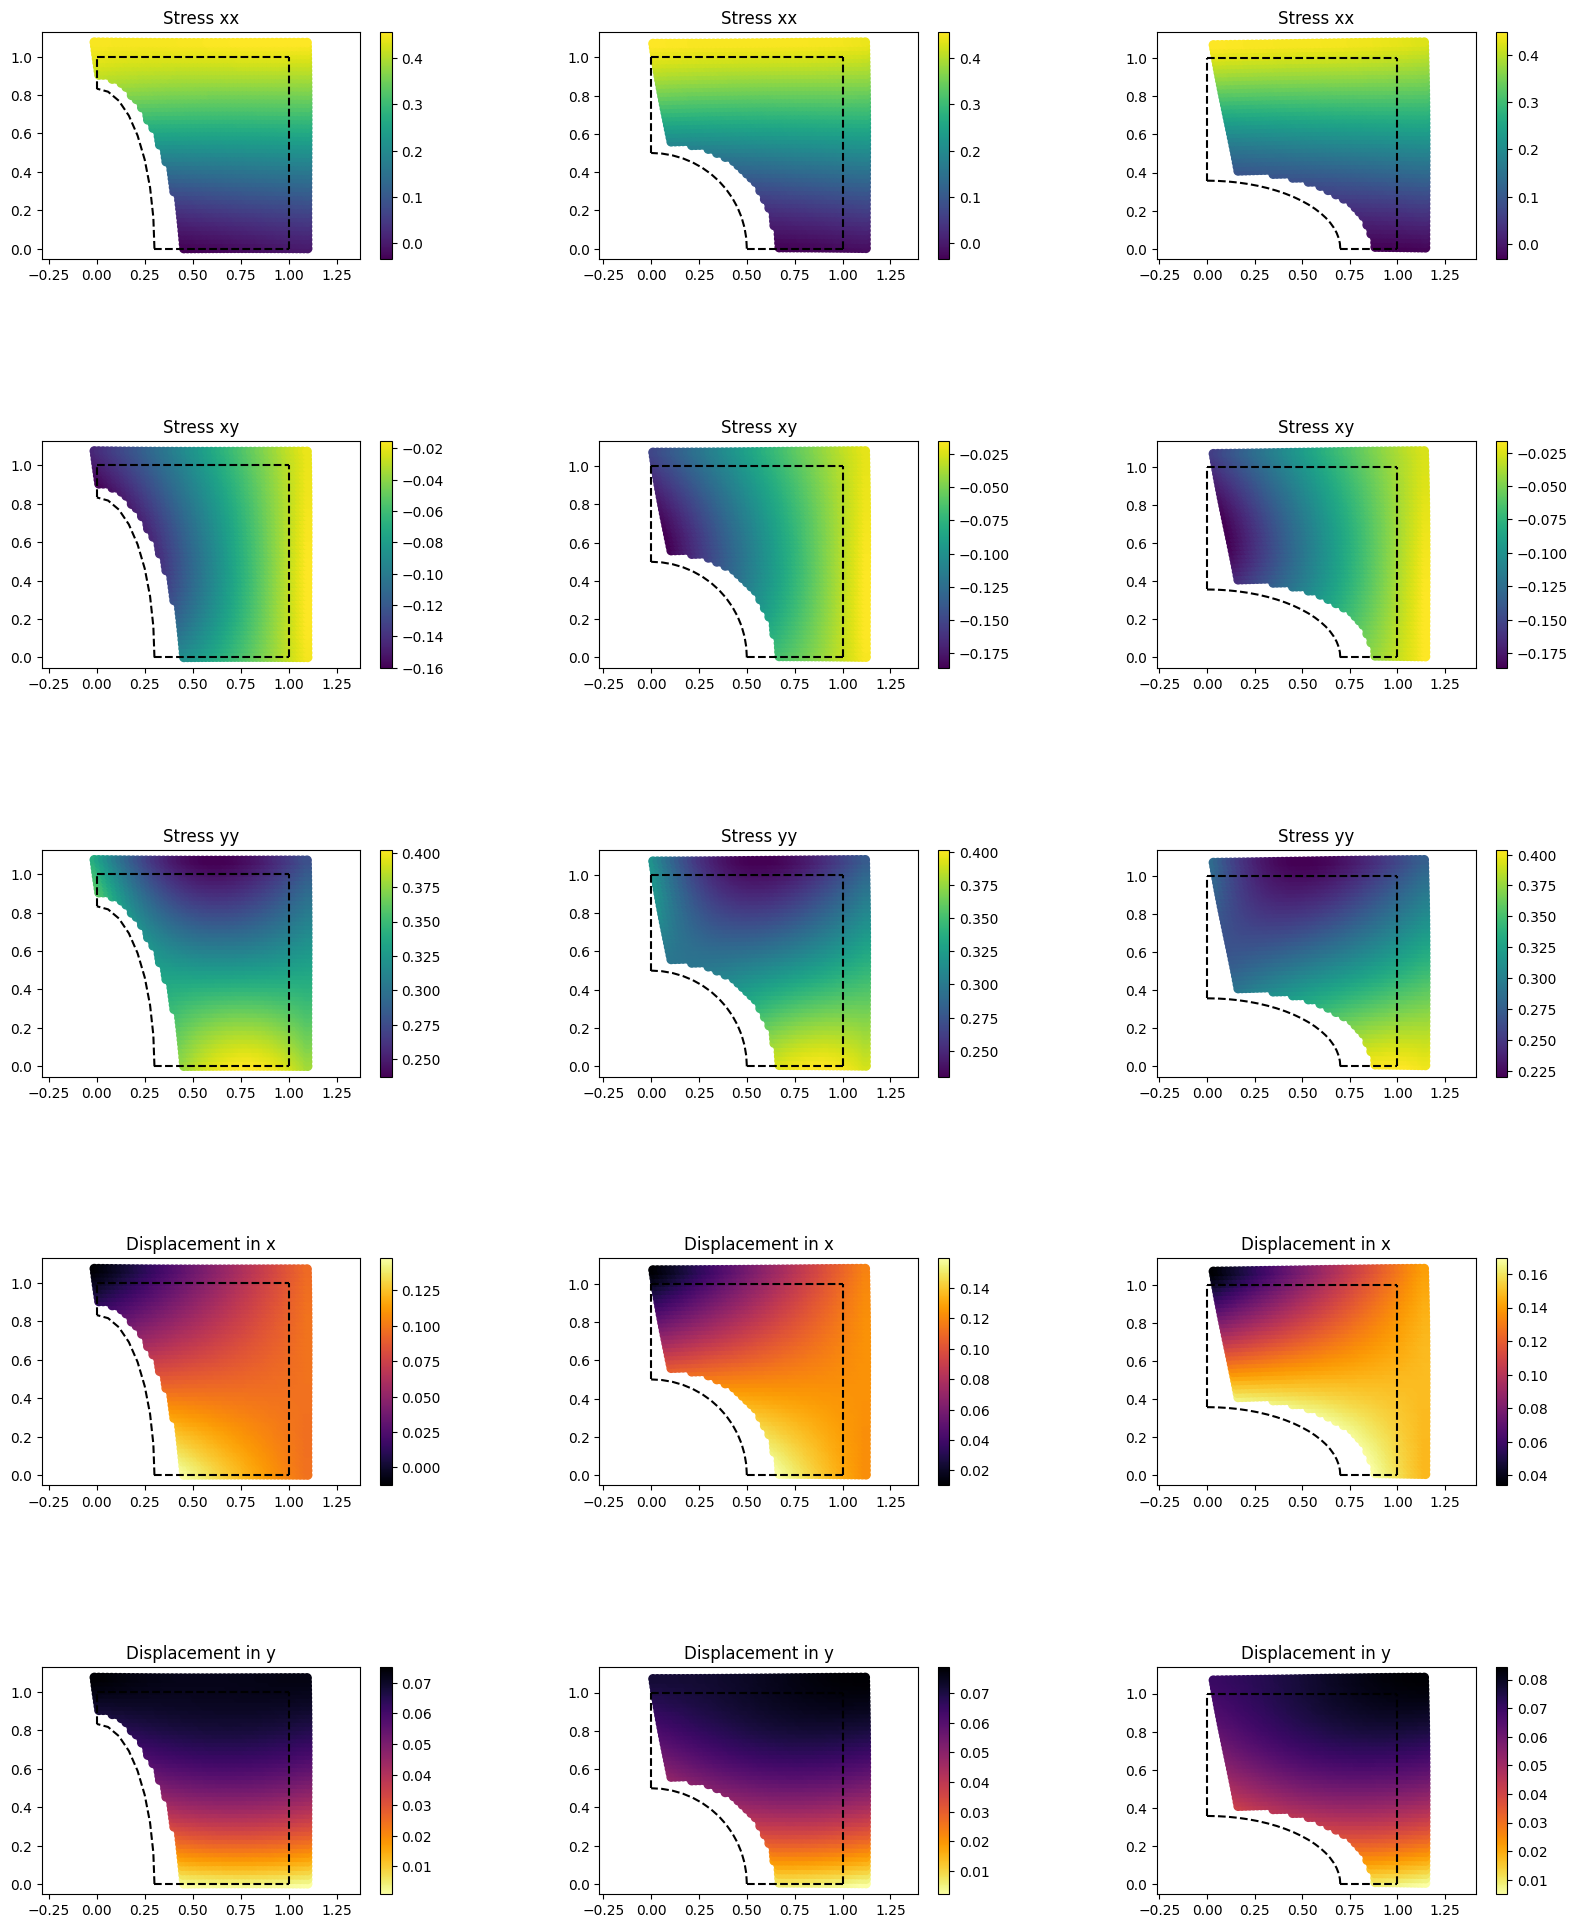

In [20]:
# Create a validation domain different from the training domain
val_x, val_y = np.meshgrid(np.linspace(0, L, 50), np.linspace(0, L, 50))
val_r = np.linspace(Min_Ra_x, Max_Ra_x, 2500)
val_ry = val_r
for i in range(2500):
    val_ry[i] = (SuAr/(pi*val_r[i])) 
val_domain = np.vstack([val_x.ravel(), val_y.ravel(), val_r, val_ry]).T
#oldcode
#val_domain = val_domain[((val_domain[:,0] ** 2)/(Re_xnew**2)) + ((val_domain[:,1] ** 2)/(Re_ynew**2)) > 1]
#newcode
val_domain = val_domain[((val_domain[:,0] ** 2)/(0.0001**2)) + ((val_domain[:,1] ** 2)/(0.0001**2)) > 1]
val_x = torch.tensor(val_domain[:,0], requires_grad=True).float()
val_y = torch.tensor(val_domain[:,1], requires_grad=True).float()
val_r = torch.tensor(val_domain[:,1], requires_grad=True).float()


def delete_points_inside_the_hole(val_domain, Re_x, Re_y):
    val_domain = val_domain[((val_domain[:,0] ** 2)/(Re_x**2)) + ((val_domain[:,1] ** 2)/((Re_y)**2)) > 1]
    val_x = torch.tensor(val_domain[:,0], requires_grad=True).float()
    val_y = torch.tensor(val_domain[:,1], requires_grad=True).float()
    return val_x, val_y

def compute_model_prediction(val_x, val_y, radius):
    inputs = torch.column_stack([val_x, val_y, radius])
    disp = net(inputs).detach()
    def_val_x = val_x.detach() + disp[:, 0]
    def_val_y = val_y.detach()+ disp[:, 1]
    strain = epsilon(val_x, val_y, radius, net).detach()
    stress = sigma(strain).detach()
    residual_x, residual_y = pde_residual(val_x, val_y, radius, net)
    return def_val_x, def_val_y, residual_x, residual_y, disp, stress


def create_subplot(def_val_x,def_val_y,variable, title, cmap, boundary_points):
    #top 
    plt.plot(boundary_points[0].detach(), boundary_points[1].detach(), "--k")
    #right
    plt.plot(boundary_points[2], boundary_points[3], "--k")
    #bottom
    plt.plot(boundary_points[6], boundary_points[7], "--k")
    #left
    plt.plot(boundary_points[4], boundary_points[5], "--k")
    #hole
    plt.plot(boundary_points[8].detach(), boundary_points[9].detach(), "--k")
    plt.scatter(def_val_x, def_val_y, c=variable, cmap=cmap)
    plt.axis("equal")
    plt.colorbar()
    plt.title(title)
    
    
def create_subplot_new(def_val_x,def_val_y,variable, title, cmap, __, top_points, right_points, left_points, bottom_points, hole_points, n_hole):
    #top 
    plt.plot(top_points[0].detach(), top_points[1].detach(), "--k")
    #right
    plt.plot(right_points[0], right_points[1], "--k")
    #bottom
    plt.plot(bottom_points[0], bottom_points[1], "--k")
    #left
    plt.plot(left_points[0], left_points[1], "--k")
    #hole
    plt.plot(hole_points[0].detach(), hole_points[1].detach(), "--k")
    plt.scatter(def_val_x, def_val_y, c=variable, cmap=cmap)
    plt.axis("equal")
    plt.colorbar()
    plt.title(title)

def create_plot():

    radii = [
        (0.3, 0.8333333333333334),
        (0.5, 0.5),
        (0.7, 0.35714285714285715)
    ]

    for j in range(3):
        k = j+1
        new_val_x, new_val_y = delete_points_inside_the_hole(val_domain, radii[j][0], radii[j][1])
        new_val_r =  radii[j][0]*torch.ones_like(new_val_x)
        new_def_val_x, new_def_val_y, _, _, disp, stress = compute_model_prediction(new_val_x, new_val_y, new_val_r)

        tuples = [
            (stress[:, 0, 0], "Stress xx", "viridis"),
            (stress[:, 0, 1], "Stress xy", "viridis"),
            (stress[:, 1, 1], "Stress yy", "viridis"), 
            (disp[:, 0], "Displacement in x", "inferno"),
            (disp[:, 1], "Displacement in y", "inferno_r")
        ] 
        for i in range(5):
            plt.subplot(5,3,k)
            k += 3 
            p1 = Plate(*radii[j], L, P)
            data_points = p1.generate_dataset_new(*radii[j], L, N)
            create_subplot_new(new_def_val_x,new_def_val_y,*tuples[i],*data_points)
            #old code
            #data_points = p1.generate_dataset_test(*radii[j], L, N)
            #create_subplot(new_def_val_x,new_def_val_y,*tuples[i],data_points[1])
    plt.subplots_adjust(top = 3.99, right = 2.49, hspace=0.8, wspace=0.4)
    #plt.suptitle("Validation with different radius")
    plt.show


create_plot()



## Comparison of maximum stress at hole to high resolution FEM data

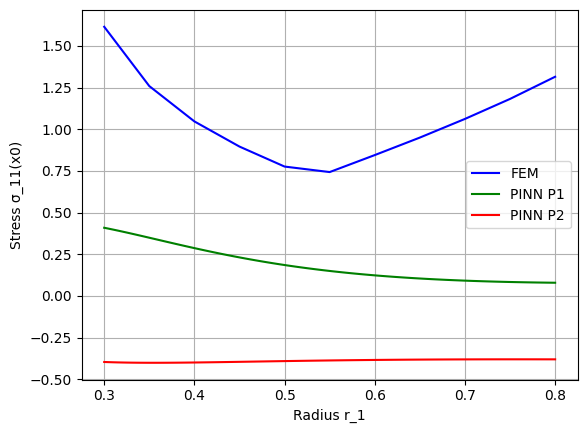

In [21]:
# FEM solution with 74745 elements
r_data = torch.tensor([0.300, 0.350, 0.400, 0.450, 0.500, 0.550, 0.600, 0.650, 0.700, 0.750, 0.800], requires_grad=True)
s_data = torch.tensor([1.615, 1.259, 1.047, 0.896, 0.776, 0.743, 0.845, 0.950, 1.062, 1.182, 1.315])
plt.plot(r_data.detach(), s_data, "b")

# Evaluate stress with PINN at upper point in hole P1
r_opti = torch.linspace(0.3, 0.8, 100, requires_grad=True)
x_opti = torch.zeros_like(r_opti, requires_grad=True)
y_opti = 0.25 / r_opti
s_opti = sigma(epsilon(x_opti, y_opti, r_opti, net))
plt.plot(r_opti.detach(), s_opti[:,0,0].detach(), "g")

# Evaluate stress with PINN at upper point in hole P2
r_opti = torch.linspace(0.3, 0.8, 100, requires_grad=True)
x_opti = 0.25 / r_opti
y_opti = torch.zeros_like(r_opti, requires_grad=True)
s_opti = sigma(epsilon(x_opti, y_opti, r_opti, net))
plt.plot(r_opti.detach(), -s_opti[:,1,1].detach(), "r")

# Plot style
plt.legend(["FEM", "PINN P1", "PINN P2"])
plt.xlabel("Radius r_1")
plt.ylabel("Stress σ_11(x0)")
plt.grid()

tensor([ 4.0865e-01,  4.0617e-01,  4.0186e-01,  3.9597e-01,  3.8877e-01,
         3.8049e-01,  3.7126e-01,  3.6121e-01,  3.5040e-01,  3.3892e-01,
         3.2682e-01,  3.1416e-01,  3.0100e-01,  2.8738e-01,  2.7337e-01,
         2.5901e-01,  2.4437e-01,  2.2951e-01,  2.1448e-01,  1.9935e-01,
         1.8417e-01,  1.6902e-01,  1.5396e-01,  1.3904e-01,  1.2432e-01,
         1.0987e-01,  9.5743e-02,  8.1987e-02,  6.8651e-02,  5.5782e-02,
         4.3417e-02,  3.1593e-02,  2.0339e-02,  9.6790e-03, -3.6885e-04,
        -9.7910e-03, -1.8579e-02, -2.6730e-02, -3.4245e-02])


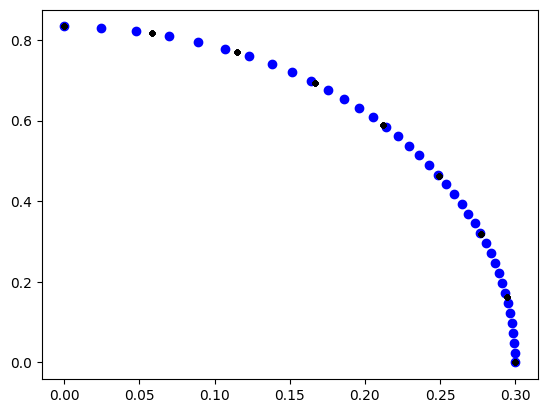

In [22]:
numbers = [0.000000000000000000e+00,8.333333333333333703e-01,
2.452989451858514011e-02,8.305429387207934333e-01,
4.792748281654195253e-02,8.226301374435216474e-01,
6.953618387276373769e-02,8.106387959096548190e-01,
8.919603768218987982e-02,7.956481782014206416e-01,
1.070194314130680224e-01,7.785057923730167584e-01,
1.232103347959008222e-01,7.598083998374453030e-01,
1.379775533264794296e-01,7.399647526147157262e-01,
1.515065593128275823e-01,7.192554074999122360e-01,
1.639530866795472774e-01,6.978769474148909246e-01,
1.754455407789077270e-01,6.759701648716118783e-01,
1.860894811171213137e-01,6.536383466250323959e-01,
1.959720370907508946e-01,6.309590043230287604e-01,
2.051655182234181640e-01,6.079914736339846471e-01,
2.137304000979373397e-01,5.847820379213561903e-01,
2.217176452330252845e-01,5.613674145666712745e-01,
2.291705143234323561e-01,5.377771689073137518e-01,
2.361259788597239728e-01,5.140354339489674462e-01,
2.426158297176931877e-01,4.901621647304341689e-01,
2.486675606232967850e-01,4.661740473510558314e-01,
2.543050616559134336e-01,4.420851795114315030e-01,
2.595491831765279200e-01,4.179075932387888992e-01,
2.644181784025029791e-01,3.936516538972976154e-01,
2.689280696061485676e-01,3.693263674024256371e-01,
2.730929518282994017e-01,3.449396242901971998e-01,
2.769252416109211912e-01,3.204983936769392194e-01,
2.804358809677504061e-01,2.960088812432921102e-01,
2.836345054889835016e-01,2.714766553071852329e-01,
2.865295823757447180e-01,2.469067495996355444e-01,
2.891285239474245539e-01,2.223037492748983213e-01,
2.914377969362113019e-01,1.976718666712444228e-01,
2.934629969353858558e-01,1.730149961288664495e-01,
2.952089221640475381e-01,1.483367751406889090e-01,
2.966796307063978566e-01,1.236406204394842473e-01,
2.978784833975859359e-01,9.892977095822821920e-02,
2.988081796628043740e-01,7.420733282628932947e-02,
2.994707882243266006e-01,4.947629332363927268e-02,
2.998677705726471854e-01,2.473956258353538981e-02,
2.999999999999999889e-01,-1.020538999289461047e-16]

numbers_x = numbers[::2]
numbers_y = numbers[1::2]


x_opti = torch.tensor(numbers_x, requires_grad=True)
y_opti = torch.tensor(numbers_y, requires_grad=True)
r_opti = 0.3*torch.ones_like(x_opti)
s_opti = sigma(epsilon(x_opti, y_opti, r_opti, net))

# x_opti = n_hole_points[:,0]
# y_opti = n_hole_points[:,1]
# r_opti = n_hole_points[:,2]
# s_opti = sigma(epsilon(x_opti, y_opti, r_opti, net))

print(s_opti[:,0,0].detach())
#print(s_opti.detach())


plt.plot(numbers_x, numbers_y, 'bo')
plt.plot(numbers_x[0], numbers_y[0],  ".r")
plt.plot(n_hole_points[:,0].detach(), n_hole_points[:,1].detach(), ".k")

In [23]:
strain_03 = epsilon(inputs_Rx_03[:,0], inputs_Rx_03[:,1], inputs_Rx_03[:,2], net).detach()
pred_stress_03 = sigma(strain_03).detach()
DATA_error_03 = mse(pred_stress_03[:, 0, 0], outputs_Rx_03[:,0])
print(pred_stress_03[:, 0, 0])
print(outputs_Rx_03[:,0])
print(DATA_error_03)

tensor([ 0.4087, -0.0342,  0.4521,  ...,  0.4136,  0.2708,  0.2895])
tensor([1.5918, 0.0020, 0.7096,  ..., 1.0279, 0.1676, 0.1802],
       grad_fn=<SelectBackward0>)
tensor(0.0171, grad_fn=<MseLossBackward0>)
